In [70]:
import torch, torchvision
import numpy as np
import torch
from matplotlib import pyplot as plt
from scipy.signal import convolve2d
from torch import tensor, Tensor
import torchvision
from tqdm import tqdm
import os
from torch import nn
from torch.utils.data import DataLoader, Subset
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [71]:
def create_negative_image(image_1: Tensor, image_2: Tensor):
    assert image_1.shape == image_2.shape, "Incompatible images and mask shapes."

    mask = create_mask((image_1.shape[0], image_1.shape[1]))

    image_1 = torch.mul(image_1, mask)
    image_2 = torch.mul(image_2, 1 - mask)

    return torch.add(image_1, image_2)

def prepare_data():
    # Define the transform function
    transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor()
    ])

    # Load the train MNIST dataset
    train_mnist_dataset = torchvision.datasets.MNIST(root="./", train=True, transform=transform,
                                                     download=False)
    n_train_samples = len(train_mnist_dataset)
    # Load the test MNIST dataset
    test_mnist_dataset = torchvision.datasets.MNIST(root="./", train=False, transform=transform,
                                                    download=False)

    if not os.path.exists("transformed_dataset.pt"):
        random_pairs = np.random.randint(n_train_samples, size=[n_train_samples, 2])
        random_pairs = [(row[0], row[1]) for row in random_pairs]

        # Transform the data
        transformed_dataset = [
            create_negative_image(train_mnist_dataset[pair[0]][0].squeeze(), train_mnist_dataset[pair[1]][0].squeeze())
            for pair in tqdm(random_pairs)]

        # Save the transformed images to a folder
        torch.save(transformed_dataset, 'transformed_dataset.pt')

def create_mask(shape, iterations: int = 10):
    blur_filter_1 = np.array(((0, 0, 0), (0.25, 0.5, 0.25), (0, 0, 0)))
    blur_filter_2 = blur_filter_1.T

    # Create a random binary image
    image = np.random.randint(0, 2, size=shape)

    # Blur the image with the specified filter
    for i in range(iterations):
        image = np.abs(convolve2d(image, blur_filter_1, mode='same') / blur_filter_1.sum())
        image = np.abs(convolve2d(image, blur_filter_2, mode='same') / blur_filter_2.sum())

    # Binarize the blurred image, i.e. threshold it at 0.5
    mask = np.round(image).astype(np.uint8)

    return tensor(mask)

def create_negative_batch(images: Tensor):
    neg_imgs = []
    batch_size = images.shape[0]
    for _ in range(batch_size):
        idx1, idx2 = np.random.randint(batch_size, size=2)
        neg_imgs.append(create_negative_image(images[idx1].squeeze(), images[idx2].squeeze()))
    return torch.unsqueeze(torch.stack(neg_imgs), dim=1)

def goodness_score(pos_acts, neg_acts, threshold=2):
    pos_goodness = -torch.sum(torch.pow(pos_acts, 2)) + threshold
    neg_goodness = torch.sum(torch.pow(neg_acts, 2)) - threshold
    return torch.add(pos_goodness, neg_goodness)

def get_metrics(preds, labels):
    acc = accuracy_score(labels, preds)
    return dict(accuracy_score=acc)

In [72]:
class FF_Layer(nn.Linear):
    def __init__(self, in_features: int, out_features: int, n_epochs: int, bias: bool, device):
        super().__init__(in_features, out_features, bias=bias)
        self.n_epochs = n_epochs
        self.opt = torch.optim.Adam(self.parameters())
        self.goodness = goodness_score
        self.to(device)
        self.ln_layer = nn.LayerNorm(normalized_shape=[1, out_features]).to(device)

    def ff_train(self, pos_acts, neg_acts):
        self.opt.zero_grad()
        goodness = self.goodness(pos_acts, neg_acts)
        goodness.backward()
        self.opt.step()

    def forward(self, input):
        input = super().forward(input)
        input = self.ln_layer(input.detach())
        return input

In [73]:

class Unsupervised_FF(nn.Module):
    def __init__(self, n_layers: int = 4, n_neurons=2000, input_size: int = 28 * 28, n_epochs: int = 100,
                 bias: bool = True, n_classes: int = 10, n_hid_to_log: int = 3, device=torch.device("cuda:0")):
        super().__init__()
        self.n_hid_to_log = n_hid_to_log
        self.n_epochs = n_epochs
        self.device = device

        ff_layers = [
            FF_Layer(in_features=input_size if idx == 0 else n_neurons,
                     out_features=n_neurons,
                     n_epochs=n_epochs,
                     bias=bias,
                     device=device) for idx in range(n_layers)]

        self.ff_layers = ff_layers
        self.last_layer = nn.Linear(in_features=n_neurons * n_hid_to_log, out_features=n_classes, bias=bias)
        self.to(device)
        self.opt = torch.optim.Adam(self.last_layer.parameters())
        self.loss = torch.nn.CrossEntropyLoss(reduction="mean")

    def train_ff_layers(self, pos_dataloader, neg_dataloader):
        outer_tqdm = tqdm(range(self.n_epochs), desc="Training FF Layers", position=0)
        for epoch in outer_tqdm:
            inner_tqdm = tqdm(zip(pos_dataloader, neg_dataloader), desc=f"Training FF Layers | Epoch {epoch}",
                              leave=False, position=1)
            for pos_data, neg_imgs in inner_tqdm:
                pos_imgs, _ = pos_data
                pos_acts = torch.reshape(pos_imgs, (pos_imgs.shape[0], 1, -1)).to(self.device)
                neg_acts = torch.reshape(neg_imgs, (neg_imgs.shape[0], 1, -1)).to(self.device)

                for idx, layer in enumerate(self.ff_layers):
                    pos_acts = layer(pos_acts)
                    neg_acts = layer(neg_acts)
                    layer.ff_train(pos_acts, neg_acts)

    def train_last_layer(self, dataloader: DataLoader):
        num_examples = len(dataloader)
        outer_tqdm = tqdm(range(self.n_epochs), desc="Training Last Layer", position=0)
        loss_list = []
        for epoch in outer_tqdm:
            epoch_loss = 0
            inner_tqdm = tqdm(dataloader, desc=f"Training Last Layer | Epoch {epoch}", leave=False, position=1)
            for images, labels in inner_tqdm:
                images = images.to(self.device)
                labels = labels.to(self.device)
                self.opt.zero_grad()
                preds = self(images)
                loss = self.loss(preds, labels)
                epoch_loss += loss
                loss.backward()
                self.opt.step()
            loss_list.append(epoch_loss / num_examples)
            # Update progress bar with current loss
        return [l.detach().cpu().numpy() for l in loss_list]

    def forward(self, image: torch.Tensor):
        image = image.to(self.device)
        image = torch.reshape(image, (image.shape[0], 1, -1))
        concat_output = []
        for idx, layer in enumerate(self.ff_layers):
            image = layer(image)
            if idx > len(self.ff_layers) - self.n_hid_to_log - 1:
                concat_output.append(image)
        concat_output = torch.concat(concat_output, 2)
        logits = self.last_layer(concat_output)
        return logits.squeeze()

    def evaluate(self, dataloader: DataLoader, dataset_type: str = "train"):
      self.eval()
      all_labels = []
      all_preds = []
      for images, labels in dataloader:
          images = images.to(self.device)
          labels = labels.to(self.device)
          preds = self(images)
          preds = torch.argmax(preds, 1)
          all_labels.append(labels.detach().cpu())
          all_preds.append(preds.detach().cpu())
      all_labels = torch.cat(all_labels, 0).numpy()
      all_preds = torch.cat(all_preds, 0).numpy()

      metrics_dict = get_metrics(all_preds, all_labels)
      print(f"{dataset_type} dataset scores:")
      for key, value in metrics_dict.items():
          print(f"{key}: {value}")

      confusion_mat = confusion_matrix(all_labels, all_preds)
      print("\nConfusion Matrix:")
      print(confusion_mat)

      class_report = classification_report(all_labels, all_preds)
      print("\nClassification Report:")
      print(class_report)


def train(model: Unsupervised_FF, pos_dataloader: DataLoader, neg_dataloader: DataLoader):
    model.train()
    model.train_ff_layers(pos_dataloader, neg_dataloader)
    return model.train_last_layer(pos_dataloader)


def plot_loss(loss, save_path="Loss_Plot.png"):
    sns.set(style="whitegrid")

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(range(1, len(loss) + 1), loss, marker='o', linestyle='-', color='b', label='Training Loss')

    ax.set_xlabel("Epochs", fontsize=14)
    ax.set_ylabel("Loss", fontsize=14)
    ax.set_title("Training Loss Plot", fontsize=16)
    ax.legend()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    plt.savefig(save_path, bbox_inches='tight')
    plt.show()

In [74]:
prepare_data()

# Load the MNIST dataset
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])
pos_dataset = torchvision.datasets.MNIST(root='./', download=False, transform=transform, train=True)
# pos_dataset = Subset(pos_dataset, list(range(1000)))
# Create the data loader
pos_dataloader = DataLoader(pos_dataset, batch_size=64, shuffle=True, num_workers=4)

# Load the transformed images
neg_dataset = torch.stack(torch.load('transformed_dataset.pt'))
# Create the data loader
neg_dataloader = DataLoader(neg_dataset, batch_size=64, shuffle=True, num_workers=4)

# Load the test images
test_dataset = torchvision.datasets.MNIST(root='./', train=False, download=False, transform=transform)
# Create the data loader
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True, num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [75]:
device = torch.device("cuda:0")
unsupervised_ff = Unsupervised_FF(device=device, n_epochs=10)

loss = train(unsupervised_ff, pos_dataloader, neg_dataloader)

Training FF Layers:   0%|          | 0/10 [00:00<?, ?it/s]
Training FF Layers | Epoch 0: 0it [00:00, ?it/s]
Training FF Layers | Epoch 0: 7it [00:00, 68.30it/s]
Training FF Layers | Epoch 0: 14it [00:00, 63.19it/s]
Training FF Layers | Epoch 0: 22it [00:00, 68.34it/s]
Training FF Layers | Epoch 0: 30it [00:00, 69.26it/s]
Training FF Layers | Epoch 0: 37it [00:00, 68.72it/s]
Training FF Layers | Epoch 0: 45it [00:00, 70.38it/s]
Training FF Layers | Epoch 0: 53it [00:00, 70.10it/s]
Training FF Layers | Epoch 0: 61it [00:00, 70.89it/s]
Training FF Layers | Epoch 0: 69it [00:00, 70.95it/s]
Training FF Layers | Epoch 0: 77it [00:01, 71.28it/s]
Training FF Layers | Epoch 0: 85it [00:01, 69.18it/s]
Training FF Layers | Epoch 0: 93it [00:01, 69.84it/s]
Training FF Layers | Epoch 0: 101it [00:01, 71.35it/s]
Training FF Layers | Epoch 0: 109it [00:01, 72.45it/s]
Training FF Layers | Epoch 0: 117it [00:01, 70.65it/s]
Training FF Layers | Epoch 0: 125it [00:01, 71.62it/s]
Training FF Layers | Epoc

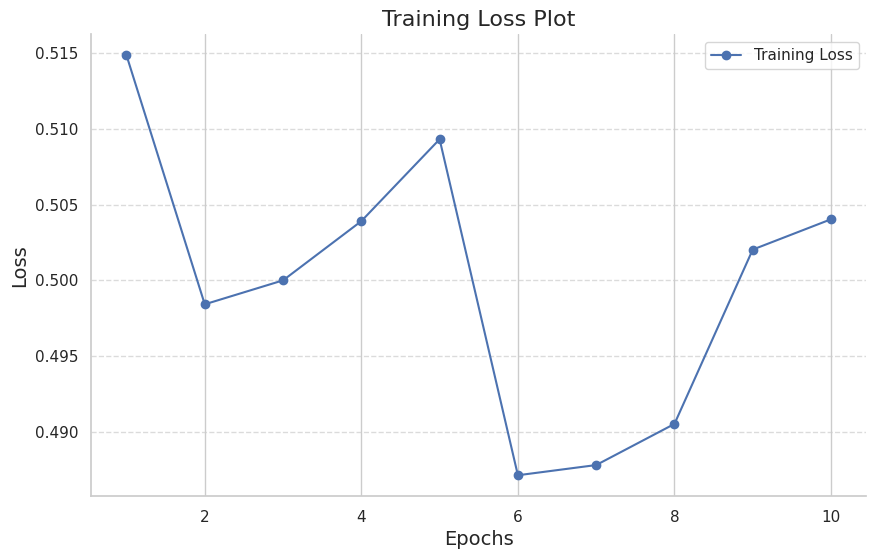

In [76]:
plot_loss(loss)

In [77]:
unsupervised_ff.evaluate(pos_dataloader, dataset_type="Train")
unsupervised_ff.evaluate(test_dataloader, dataset_type="Test")

Train dataset scores:
accuracy_score: 0.9174666666666667

Confusion Matrix:
[[5781    1   18    6    9   47   12    9   32    8]
 [   1 6444   65   72    5   49    0   13   72   21]
 [  38   20 5528  102   72   43   24   42   69   20]
 [  22    5  189 5465    8  226    6   32   82   96]
 [  28   22   38    6 5386    8   25   11   47  271]
 [  41   20   55  159   65 4853   27   23  135   43]
 [  42   13  131    7   51  204 5398    5   64    3]
 [  15   11  113   53   53   11    1 5768   20  220]
 [  29   94  140  206   33  192   14   17 5036   90]
 [  31   23   22   65  149   32    2  177   59 5389]]

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      5923
           1       0.97      0.96      0.96      6742
           2       0.88      0.93      0.90      5958
           3       0.89      0.89      0.89      6131
           4       0.92      0.92      0.92      5842
           5       0.86      0.90      0.88 

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Test dataset scores:
accuracy_score: 0.9132

Confusion Matrix:
[[ 959    0    1    3    1    9    3    3    1    0]
 [   0 1099    8   10    0    4    3    2    9    0]
 [   6    5  942   22    7    7    9    7   20    7]
 [   4    0   29  907    3   35    0   10   13    9]
 [   2    4   14    1  894    0    5    4    8   50]
 [  10    2   10   32   13  783    5    3   24   10]
 [  16    3   17    2    7   46  861    2    4    0]
 [   1    4   32   12    8    3    0  931    6   31]
 [   9    9   12   29   10   32    5    7  848   13]
 [   9    5    1   10   31    8    1   25   11  908]]

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       980
           1       0.97      0.97      0.97      1135
           2       0.88      0.91      0.90      1032
           3       0.88      0.90      0.89      1010
           4       0.92      0.91      0.91       982
           5       0.84      0.88      0.86       892
   